# Sampling

The purpose of this notebook is to showcase different types of sampling and the importance of sampling to reduce estimation errors. Most the annotations are taken verbatim from the [DataQuest](https://www.dataquest.io/) Statistics Fundamentals course. The code, however, was written by myself. I also modified and included plots and analyses not in the course, mainly the Stratified vs. Random Sampling detailed comparison.

The data set is about basketball players in WNBA (Women's National Basketball Association), and contains general information about players, along with their metrics for the season 2016-2017. The data set was put together by Thomas De Jonghe, and can be downloaded from [Kaggle](https://www.kaggle.com/jinxbe/wnba-player-stats-2017), where you can also find useful documentation for the data set.

## Random Sampling

Let's import everything we need and create some auxiliary functions to make our life easier and the code more readable :).

In [1]:
#The works
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Function to Remove the top and right spines
def simple_axis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

In [3]:
#Function to plot with annotations
def annotated_plot(population_mean, sample_means, title, max_offset=3, min_offset=3):
    sample_means = pd.Series(sample_means)    
    max_mean = sample_means.max()
    min_mean = sample_means.min()

    plt.scatter(range(1,101), sample_means, c="cyan")
    plt.scatter(sample_means.idxmax()+1,max_mean, c="red")
    plt.scatter(sample_means.idxmin()+1,min_mean, c="red")

    plt.axhline(population_mean)
    plt.ylim(100,350)

    simple_axis(plt.gca())

    plt.title(title)
    ax = plt.gca()
    ax.annotate('Population \n Mean', xy=(-15, population_mean+3))
    ax.annotate('Samples Max \n Mean', xy=(sample_means.idxmax(), max_mean+max_offset))
    ax.annotate('Samples Min \n Mean', xy=(sample_means.idxmin(), min_mean+min_offset))

    print("Population Mean:", population_mean)
    print("Sample Max Mean:", max_mean)
    print("Sample Min Mean:", min_mean)
    

In [4]:
#Generate n "completely" random samples of sample_size each. The return value is a list of the means of the generated samples.
def generate_random_samples(n=100, sample_size=10):
    sample_means = []
    for i in range(n):
        sample = wnba['PTS'].sample(sample_size, random_state=i)
        sample_means.append(sample.mean())
    return sample_means

### Random Sampling (10 observations)

('Population Mean:', 201.7902097902098)
('Sample Max Mean:', 301.4)
('Sample Min Mean:', 115.0)


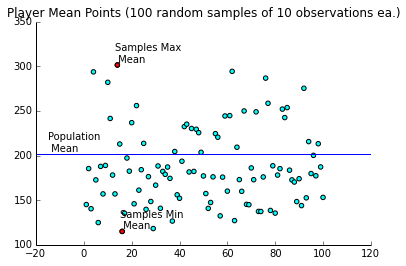

In [19]:
wnba = pd.read_csv('wnba.csv')
population_mean = wnba['PTS'].mean()
sample_means = generate_random_samples()

annotated_plot(population_mean,sample_means, "Player Mean Points (100 random samples of 10 observations ea.)")

We can notice that the sample means vary a lot around the population mean. With a minimum sample mean of 115 points, a maximum of 301.4, and a population mean of roughly 201.8, we can tell that the sampling error is quite large for some of the cases.

This problem can be solved by increasing the sample size. As we increase the sample size, the sample means vary less around the population mean, and the chances of getting an unrepresentative sample decrease.

### Random Sampling (100 observations)

('Population Mean:', 201.7902097902098)
('Sample Max Mean:', 222.05)
('Sample Min Mean:', 178.12)


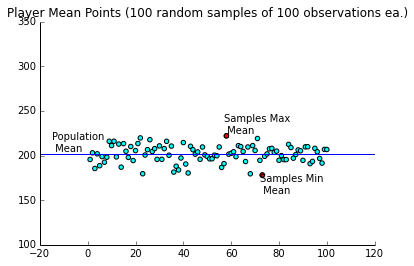

In [6]:
sample_means = pd.Series(generate_random_samples(n=100, sample_size=100))    
max_mean = sample_means.max()
min_mean = sample_means.min()
    
annotated_plot(population_mean,sample_means, "Player Mean Points (100 random samples of 100 observations ea.)", 3, -20)

Most of our sample means are now closer to the Population (true) mean. The downside of simple random sampling is that it can leave out individuals from a certaim group out. To ensure we end up with a sample that has observations for all the categories of interest, we can change the sampling method. We can organize our data set into different groups, and then do simple random sampling for every group. 

## Stratified Sampling

The problem is that the number of total points is influenced by the number of games played, which ranges from 2 to 32, and around 30% of the players are below the 22 game mark. 70% of the individuals played more than 22 games, 20% played between 13 and 22 games, and 10% played below 13 games. 

In [7]:
print ("Min Games Played", wnba['Games Played'].min())
print ("Max Games Played",wnba['Games Played'].max())

('Min Games Played', 2)
('Max Games Played', 32)


In [8]:
wnba['Games Played'].value_counts(bins = 3, normalize = True) * 100

(22.0, 32.0]     72.727273
(12.0, 22.0]     18.181818
(1.969, 12.0]     9.090909
Name: Games Played, dtype: float64

When we compute the mean of the total points using the population, the mean will probably be signficantly influenced by those 72.7% players who played more than 23 games. However, when we sample randomly, we can end up with a sample where the proportions are different than in the population. 

For instance, we might end up with a sample where only 2% of the players played more than 23 games. This will result in a sample mean which **underestimates** the population mean. Or we could have a sample where more than 95% of the players had 23 games in the 2016-2017 season. This will result in **overestimating** the population mean.

We can stratify our data set by the number of games played, and then sample randomly from each stratum a proportional number of observations.

In [9]:
#Generate n stratified samples of sample_size each. The return value is a list of the means of the generated samples.
def generate_stratified_samples(strata, n=100, sample_size=10, sample_ratios = [0.1, 0.2,0.7]):
    proportional_sampling_means = []
    for i in range(n):
        sample_a = strata[0]['PTS'].sample(int(sample_size*sample_ratios[0]), random_state = i)
        sample_b = strata[1]['PTS'].sample(int(sample_size*sample_ratios[1]), random_state = i)
        sample_c = strata[2]['PTS'].sample(int(sample_size*sample_ratios[2]), random_state = i)

        final_sample = pd.concat([sample_a, sample_b, sample_c])
        proportional_sampling_means.append(final_sample.mean())
    return proportional_sampling_means

## Strata:  Number of Games Played. 10 Observations

('Population Mean:', 201.7902097902098)
('Sample Max Mean:', 330.3)
('Sample Min Mean:', 118.4)


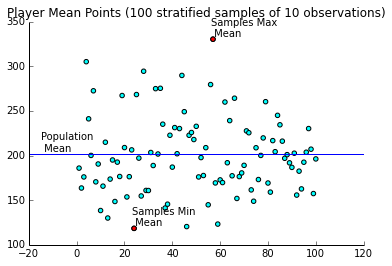

In [10]:
group_a = wnba[wnba['Games Played'] <= 12]
group_b = wnba[(wnba['Games Played'] > 12) & (wnba['Games Played'] <= 22)]
group_c = wnba[wnba['Games Played'] > 22]

strata= [group_a,group_b,group_c]
proportional_sampling_means = generate_stratified_samples(strata)
    
annotated_plot(population_mean,proportional_sampling_means, "Player Mean Points (100 stratified samples of 10 observations)")

**Unimpressive**. The variability of the stratified sampling was quite large, and many sample means were unrepresentative, being far from the population mean.This sampling method doesn't seem to perform better than _simple random sampling_. 

The poor performance is caused by a bad choice of strata. We stratified the data by the number of games played, but this isn't a good approach. A player is considered as having played one game even if she only played for one or two minutes, but others play 30 or 40 minutes. Therefore, it makes more sense to stratify the data by number of minutes played.

Here are a few guidelines for choosing good strata:

**1. Minimize the variability within each stratum.**

For instance, avoid having in the same stratum a player that has scored 10 points and one that has scored 500. If the variability is high, it might be a sign that you either need a more granular stratification (more strata!), or you need to change the criterion of stratification (an example of criterion is minutes played).

**2. Maximize the variability between strata.**

If you have strata that are similar to one another with respect to what you want to measure, you might need a more granular stratification, or to change the stratification criterion. 

**3. The stratification criterion should be strongly correlated with the property you're trying to measure.**

## Strata:  Number of Minutes Played. 15 Observations

Let's use Number of minutes played as a criterion to split the data in strata.

In [11]:
print(wnba['MIN'].value_counts(bins = 3, normalize = True))

(347.333, 682.667]    0.349650
(10.993, 347.333]     0.335664
(682.667, 1018.0]     0.314685
Name: MIN, dtype: float64


The number of players are evenly distributed throughout the different strata.

('Population Mean:', 201.7902097902098)
('Sample Max Mean:', 253.26666666666668)
('Sample Min Mean:', 165.66666666666666)


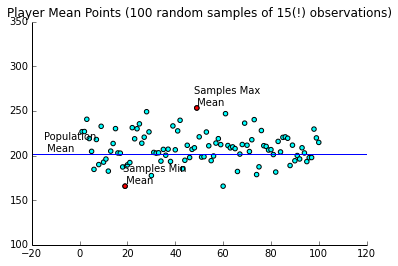

In [12]:
group_a = wnba[wnba.MIN <= 347]
group_b = wnba[(wnba.MIN > 347) & (wnba.MIN <= 683)]
group_c = wnba[wnba.MIN > 683]

strata= [group_a,group_b,group_c]
proportional_sampling_means = generate_stratified_samples(strata, sample_size = 15, sample_ratios=[1.0/3.0]*3)
    
annotated_plot(population_mean,proportional_sampling_means, "Player Mean Points (100 random samples of 15(!) observations)")

**Elpo's notes :** It is important to stress that with only 15 observations the representativity of the mean scored points considerably increases. This technique is useful in situations in which it is cost-effective to reduce the number of sampled observations (all of them? sampling is rarely free). Yes, we began with population data fully available and thus were able to extract the strata ratios. In practice this is seldom feasible, unless, for example, we are working with a comparable population (e.g.: Voter data from previous elections). Let's see the difference between stratified and random sampling with increasing number of observations.

In [13]:
import os, sys

#Supress output from print
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

### Comparing Stratified and Random Sampling 

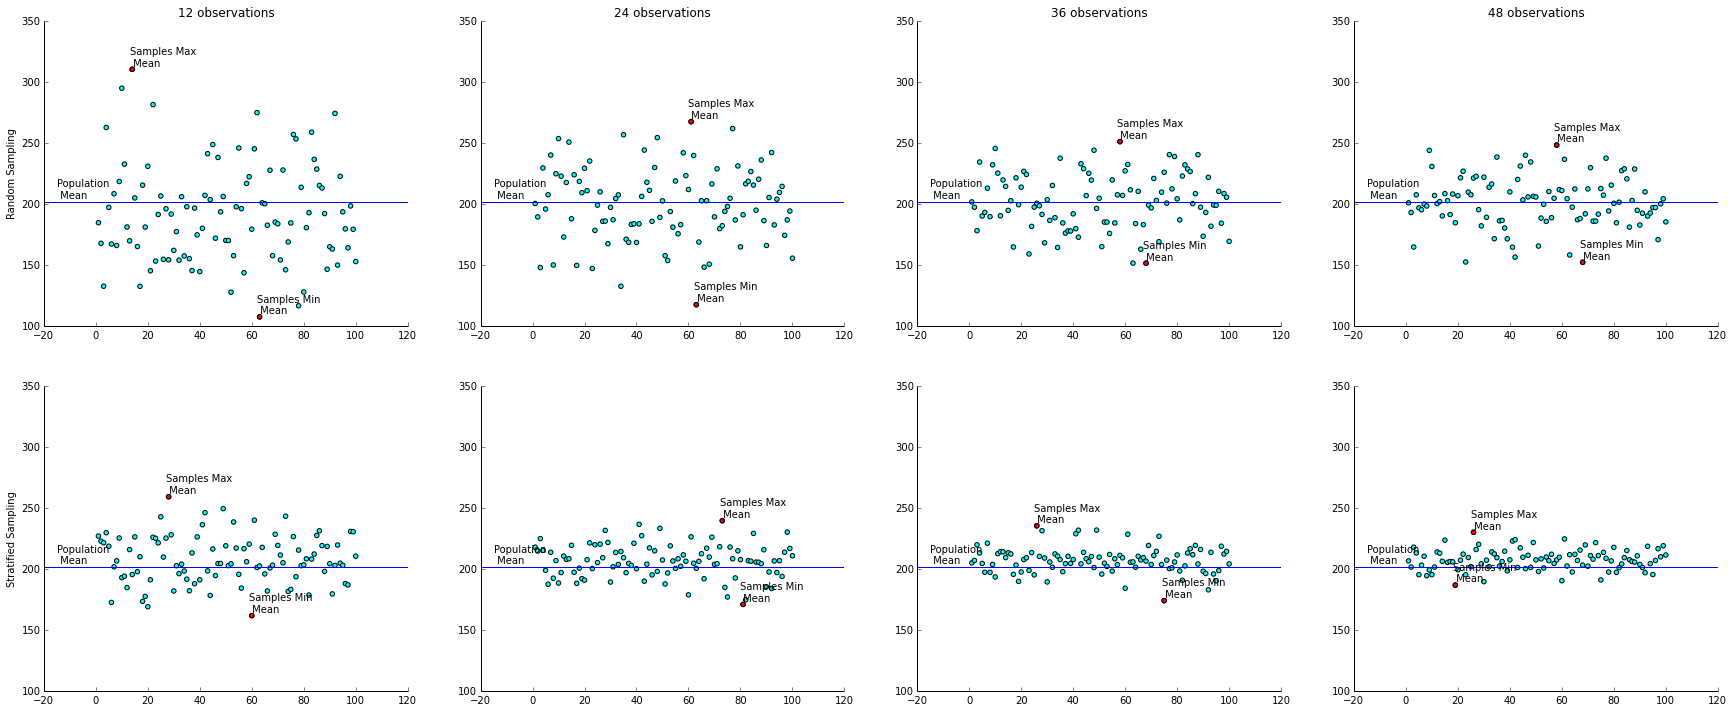

In [14]:
fig = plt.figure(figsize=(30, 12))

with HiddenPrints():
    for x in range(1,5):
        
        sample_means = generate_random_samples(100,12*x)
        ax = fig.add_subplot(2, 4, x)
        annotated_plot(population_mean,sample_means, "%i observations"%(12*x))
        if(x == 1):
            ax.set_ylabel("Random Sampling")
            
        proportional_sampling_means = generate_stratified_samples(strata, sample_size = 12*x, sample_ratios=[1.0/3.0]*3)
        ax = fig.add_subplot(2, 4, x+4)
        annotated_plot(population_mean,proportional_sampling_means, "")
        if(x == 1):
            ax.set_ylabel("Stratified Sampling")        

Stratified sampling starts looking good enough at 36 observations, while random sampling still has room for improvement. Let's plot the [MSE](https://en.wikipedia.org/wiki/Mean_squared_error) of the approximations versus number of observations to visualize the rate of change of the improvement.

### Plotting the MSE as a function of sample size for Random and Stratified Sampling

('Maximum possible observations:', 143)


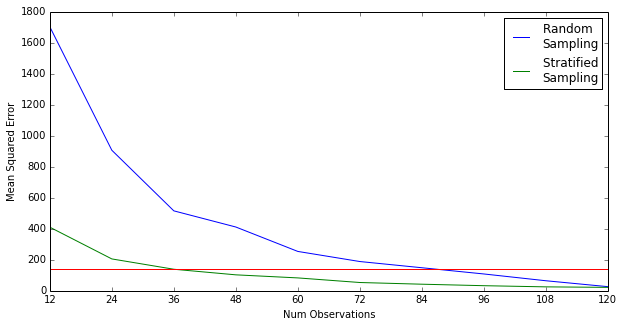

In [15]:
import numpy as np
import matplotlib.ticker as tck

fig = plt.figure(figsize=(10, 5))

MSE_random_sampling =[]
MSE_stratified_sampling = []

for x in range(1,11):
    sample_means = generate_random_samples(100,12*x)
    MSE_random_sampling.append(np.mean((population_mean - sample_means)**2))
    
    proportional_sampling_means = generate_stratified_samples(strata, sample_size = 12*x, sample_ratios=[1.0/3.0]*3)
    MSE_stratified_sampling.append(np.mean((population_mean - proportional_sampling_means)**2))


plt.plot(range(1,11), MSE_random_sampling, label = "Random \nSampling")
plt.plot(range(1,11), MSE_stratified_sampling, label = "Stratified \nSampling")

ax = plt.gca()
ax.set_xlabel("Num Observations")
ax.set_ylabel("Mean Squared Error")
ax.xaxis.set_major_formatter(tck.FuncFormatter(lambda x, pos:'%g'%(12*x)))
plt.axhline(140, color = "red")
plt.legend()

print("Maximum possible observations:" , wnba.shape[0])


So, Stratified sampling at 36 observations is as good as Random sampling at ~86 samples, saving ourselves the trouble of conducting 50 extra surveys, yay!. Also, even at 12 samples (under 10% of the total samples) it has a low enough MSE.

### Closing Remarks: 

It could be that you need to collect data from an API that either has usage limit, or is not free. In this case, you are more or less forced to sample. Knowing how and what to sample can be of great use.

If you're interested in some categories beforehand, it might be a good idea to use stratified sampling.

Another common use case of sampling is when the data is scattered across different locations (different websites, different databases, different companies, etc.). Cluster sampling would be a great choice in such a scenario.

**Bonus/おまけ/Pilón**: Let's take a look the distribution of player positions in the dataset.

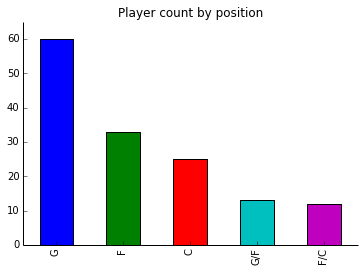

In [16]:
wnba.Pos.value_counts().plot.bar()
plt.ylim(0,65)
plt.title("Player count by position")
simple_axis(plt.gca())

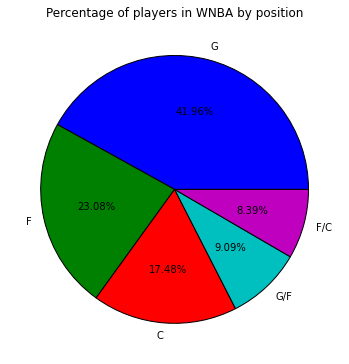

In [17]:
wnba.Pos.value_counts().plot.pie(figsize = (6,6), autopct = "%.2f%%", title = "Percentage of players in WNBA by position")

ax = plt.gca()
ax.set_ylabel("")

And which position scores the most points.

In [18]:
wnba['Pts_per_game'] = wnba['PTS'] / wnba['Games Played']

# Stratifying the data in five strata
stratum_G = wnba[wnba.Pos == 'G']
stratum_F = wnba[wnba.Pos == 'F']
stratum_C = wnba[wnba.Pos == 'C']
stratum_GF = wnba[wnba.Pos == 'G/F']
stratum_FC = wnba[wnba.Pos == 'F/C']

points_per_position = {}
for stratum, position in [(stratum_G, 'G'), (stratum_F, 'F'), (stratum_C, 'C'),
                (stratum_GF, 'G/F'), (stratum_FC, 'F/C')]:
    
    sample = stratum['Pts_per_game'].sample(12, random_state = 0) # simple random sapling on each stratum
    points_per_position[position] = sample.mean()
    
#Key takes a lambda expression or function and applies it to the elements of the first argument. Max is applied to the results.
position_most_points = max(points_per_position, key = points_per_position.get)
position_most_points

'C'